In [1]:
from _utils import *
from scipy.stats import qmc

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

def calculate_distance_map(polys):
    # Extract the dimensions of the input array
    num_probes, num_coords, num_cells = polys.shape
    
    # Initialize an array of the same shape to hold the interpolated values
    new_maps = np.zeros((num_cells, num_probes, num_probes))
    
    # Iterate over each cell
    for c in range(num_cells):
        # Extract the data for the current cell
        curr_cells = polys[:, :, c]
        
        # Skip cells with all missing values
        if np.all(np.isnan(curr_cells)):
            continue  # This leaves a matrix of zeros in the output array
        
        # Calculate the pairwise Euclidean distance between each pair of probes
        dmap = squareform(pdist(curr_cells))
        
        # Assign the distance map to the corresponding position in the output array
        new_maps[c, :, :] = dmap
    
    # Return the array with interpolated values
    return new_maps

esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=None)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

all_maps_pca = np.concatenate((esc_maps_pca, cnc_maps_pca), axis=0)

# Use Latin Hypercube sampling to generate 1000 samples
# This technique tries to sample data points in a way that they are evenly distributed

num_microstates = 1000
num_dimension = pca.n_components_  # pca.n_components_

sampler = qmc.LatinHypercube(d=num_dimension)
sample = sampler.random(n=num_microstates)

# We can use quantiles to get physical bounds
l_quantile = 0.01
u_quantile = 1 - l_quantile
l_bounds = np.quantile(all_maps_pca, l_quantile, axis=0)
u_bounds = np.quantile(all_maps_pca, u_quantile, axis=0)
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

# Add these sample_scaled coordinates to a dataframe
sample_df = pd.DataFrame(sample_scaled, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Inverse transform the samples
microstates_maps = pca.inverse_transform(sample_scaled)


2024-10-16 21:38:55.032372: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 21:38:55.475355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mcmc_common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results'

# Find all the folders in the MCMC result directory with 'Kmedoid' in the name
mcmc_folders = [f for f in os.listdir(mcmc_common_dir) if 'Rank' in f]

# Get the full path to each of the folders
mcmc_folders = [os.path.join(mcmc_common_dir, f) for f in mcmc_folders]

num_microstates = 1000

# Sort based on the number in the filename 
# Number is in the last part after the last underscore
mcmc_folders.sort(key=lambda x: int(x.split('_')[-1][4:]))

# Extract the number of clusters from the folder names
num_ranks = [int(f.split('_')[-1][4:]) for f in mcmc_folders]

In [3]:
num_ranks

[2, 10, 50, 500]

In [4]:
def load_mcmc_results(mcmc_path, num_microstates):
    # Find stan_output folder path and then load the MCMC samples
    # List all items in the current directory
    mcmc_result = {}
    for item in tqdm(os.listdir(mcmc_path)):
        # Get the full path of the item
        full_path = os.path.join(mcmc_path, item)
        
        # Check if the item is a directory
        # And if the directory contains stan_output folder
        # Check if 'stan_output' exists in the directory
        folder_path = os.path.join(full_path, 'stan_output')
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            # Load the MCMC results
            mcmc_result[item] = load_weights(folder_path, num_microstates)
            
    return mcmc_result

In [5]:
mcmc_results = []
for i, k in enumerate(num_ranks):
    mcmc_results.append(load_mcmc_results(mcmc_folders[i], k))

  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241014205826_1.csv', '20240715_WeightOptimization-20241014205826_2.csv', '20240715_WeightOptimization-20241014205826_3.csv', '20240715_WeightOptimization-20241014205826_4.csv']
['20240715_WeightOptimization-20241014205826_1.csv', '20240715_WeightOptimization-20241014205826_2.csv', '20240715_WeightOptimization-20241014205826_3.csv', '20240715_WeightOptimization-20241014205826_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241014205628_1.csv', '20240715_WeightOptimization-20241014205628_2.csv', '20240715_WeightOptimization-20241014205628_3.csv', '20240715_WeightOptimization-20241014205628_4.csv']
['20240715_WeightOptimization-20241014205628_1.csv', '20240715_WeightOptimization-20241014205628_2.csv', '20240715_WeightOptimization-20241014205628_3.csv', '20240715_WeightOptimization-20241014205628_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241014205418_1.csv', '20240715_WeightOptimization-20241014205418_2.csv', '20240715_WeightOptimization-20241014205418_3.csv', '20240715_WeightOptimization-20241014205418_4.csv']
['20240715_WeightOptimization-20241014205419_1.csv', '20240715_WeightOptimization-20241014205419_2.csv', '20240715_WeightOptimization-20241014205419_3.csv', '20240715_WeightOptimization-20241014205419_4.csv']


  0%|          | 0/3 [00:00<?, ?it/s]

['20240715_WeightOptimization-20241014204229_1.csv', '20240715_WeightOptimization-20241014204229_2.csv', '20240715_WeightOptimization-20241014204229_3.csv', '20240715_WeightOptimization-20241014204229_4.csv']
['20240715_WeightOptimization-20241014204229_1.csv', '20240715_WeightOptimization-20241014204229_2.csv', '20240715_WeightOptimization-20241014204229_3.csv', '20240715_WeightOptimization-20241014204229_4.csv']


In [6]:
mcmc_weights_esc = []
mcmc_weights_cnc = []

entropy_dfs = []

for i, k in enumerate(num_ranks):
    curr_sample = mcmc_results[i]
    curr_sample_esc = curr_sample['ESC']
    curr_sample_cnc = curr_sample['CNC']
    
    esc_weights = np.exp(np.array(curr_sample_esc))
    cnc_weights = np.exp(np.array(curr_sample_cnc))
    
    esc_weights = esc_weights.reshape(-1, k)
    cnc_weights = cnc_weights.reshape(-1, k)
    
    mcmc_weights_esc.append(esc_weights)
    mcmc_weights_cnc.append(cnc_weights)
    
    esc_entropy_all = calculate_entropy(esc_weights)
    cnc_entropy_all = calculate_entropy(cnc_weights)
    
    esc_entropy_df = pd.DataFrame({'entropy': esc_entropy_all, 'label': 'ESC'})
    cnc_entropy_df = pd.DataFrame({'entropy': cnc_entropy_all, 'label': 'CNC'})
    
    entropy_df = pd.concat([esc_entropy_df, cnc_entropy_df])
    entropy_dfs.append(entropy_df)

In [7]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20241016'

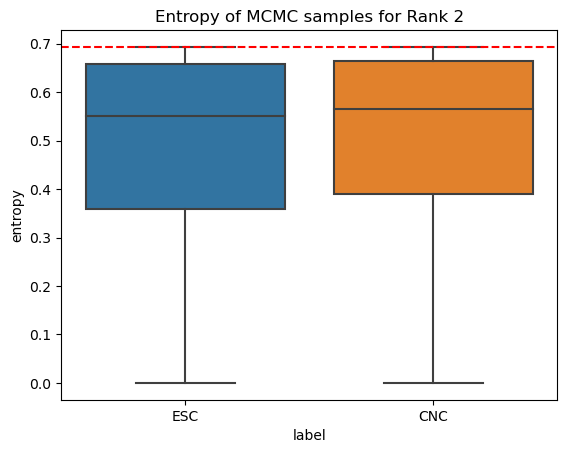

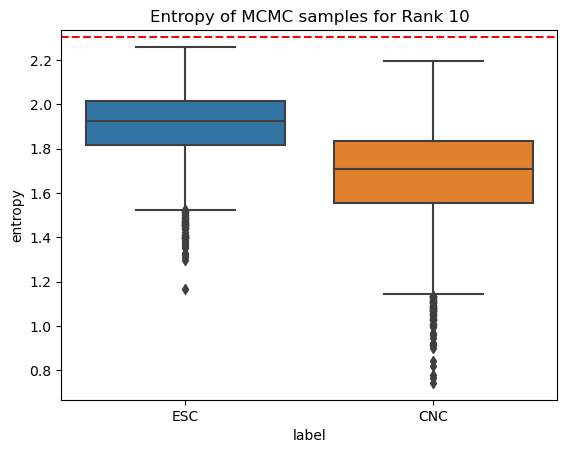

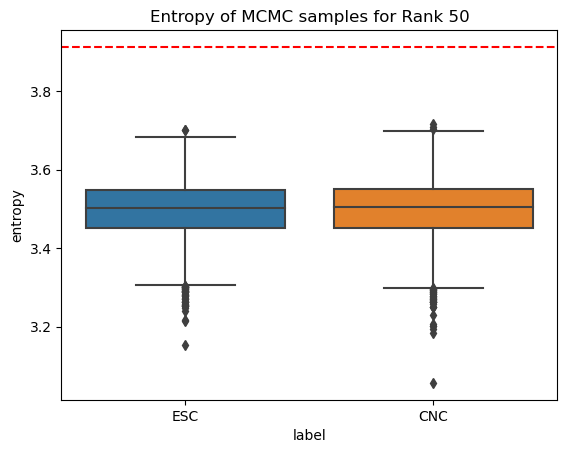

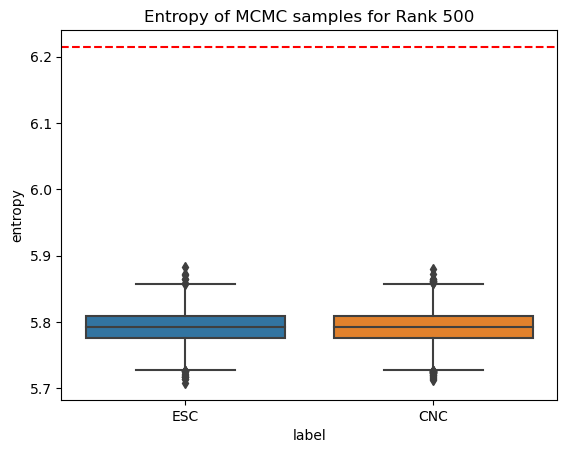

In [8]:
for i, entropy_df in enumerate(entropy_dfs):
    sns.boxplot(data=entropy_df, x='label', y='entropy')
    # plot horizontal lines at y = log(k)
    plt.axhline(y=np.log(num_ranks[i]), color='r', linestyle='--')
    plt.title(f'Entropy of MCMC samples for Rank {num_ranks[i]}')
    plt.savefig(f'{save_dir}/LHS_entropy_{num_ranks[i]}_microstates.png')
    plt.show()

In [9]:
# Load parameters for medoids
md_params = []
for f in mcmc_folders:
    with open(os.path.join(f, 'sampled_microstates.csv'), 'r') as file:
        # load into a pandas dataframe
        df = pd.read_csv(file)
        # append to the list
        md_params.append(df)

In [24]:
type(md_params[0])

pandas.core.frame.DataFrame

In [10]:
pca_list = []
microstates_list = []
for i, k in enumerate(num_ranks):
    pca = PCA(n_components=k)
    pca.fit(all_maps_interp_flat)
    pca_list.append(pca)
    microstate = pca.inverse_transform(md_params[i].values)
    microstates_list.append(microstate)

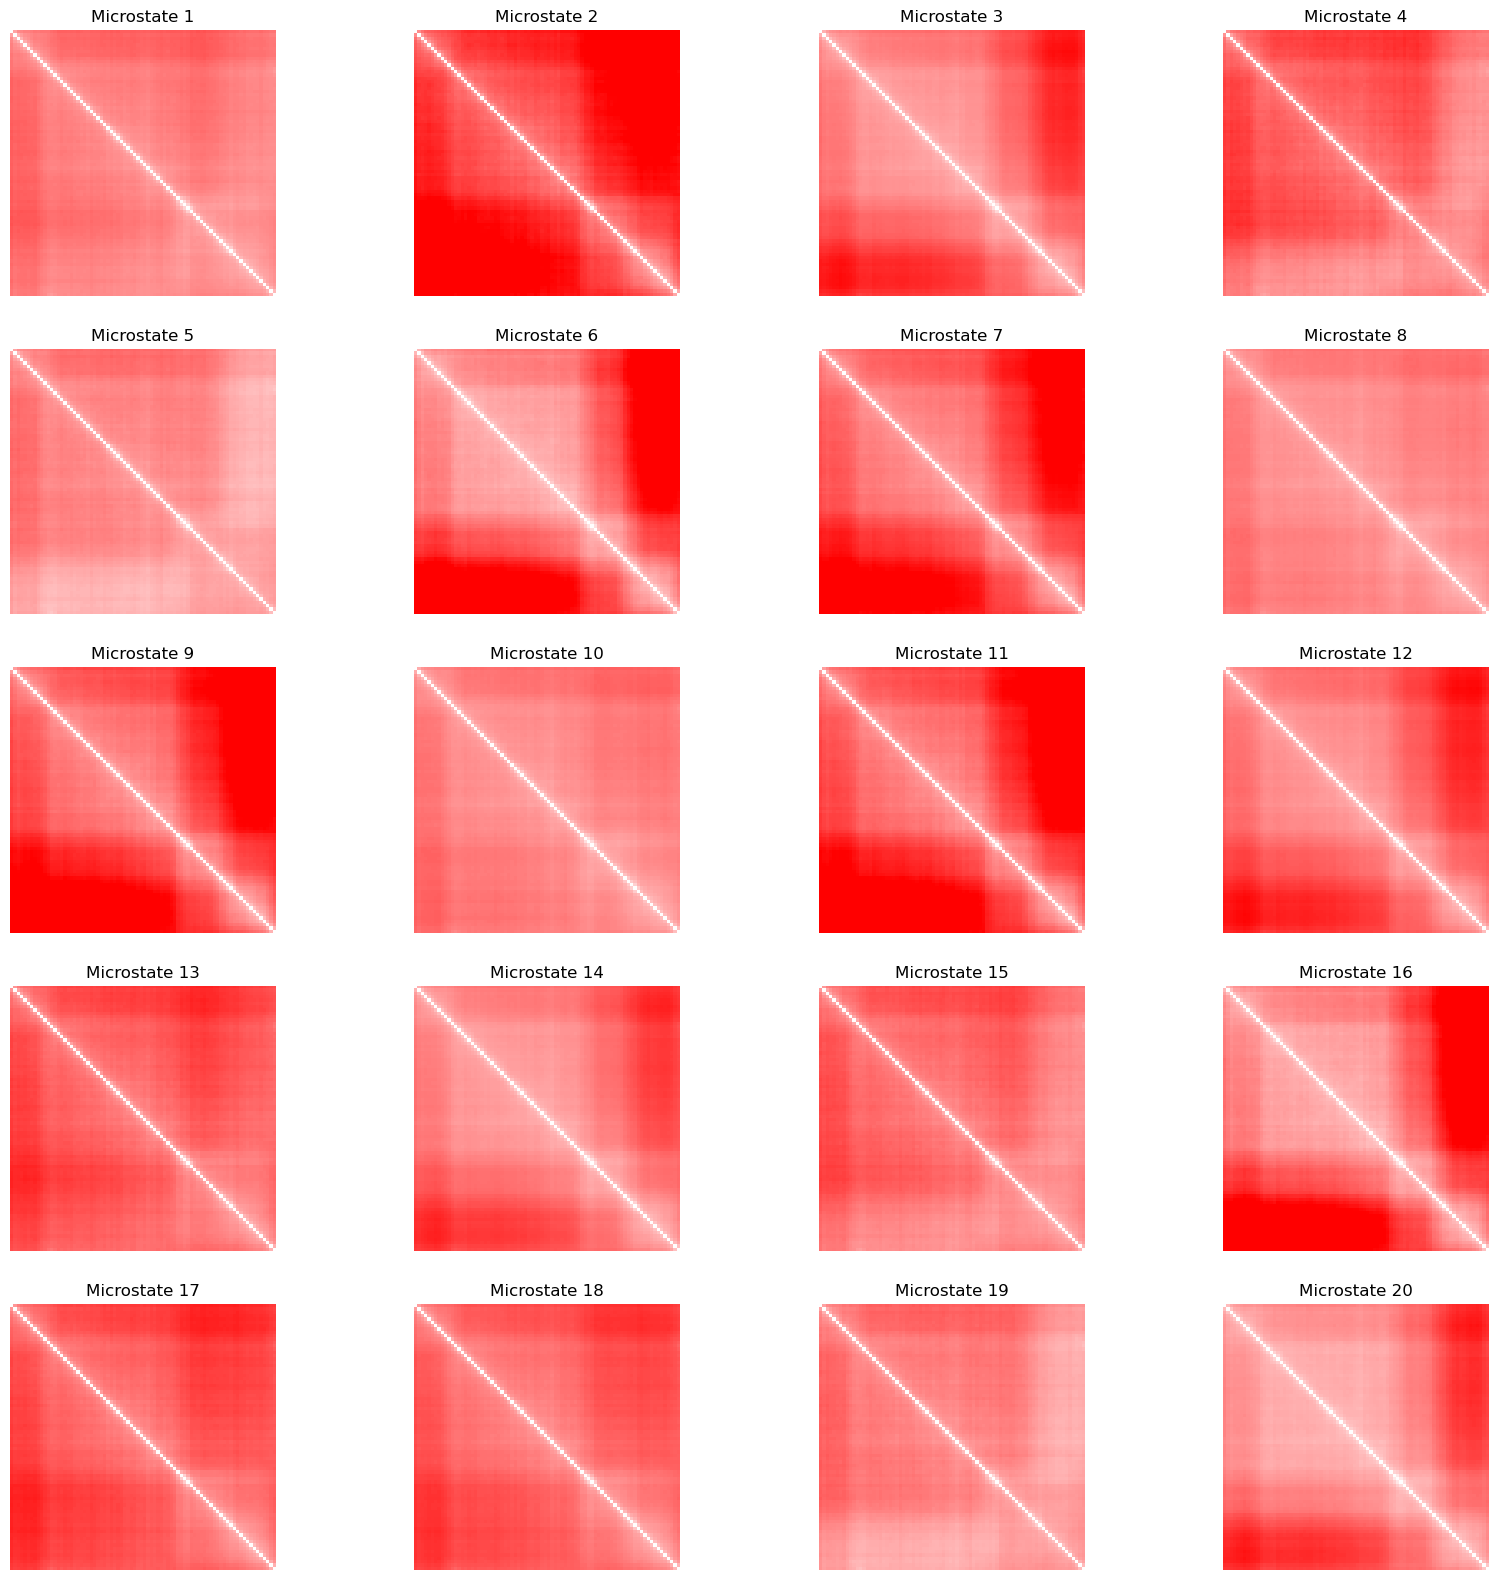

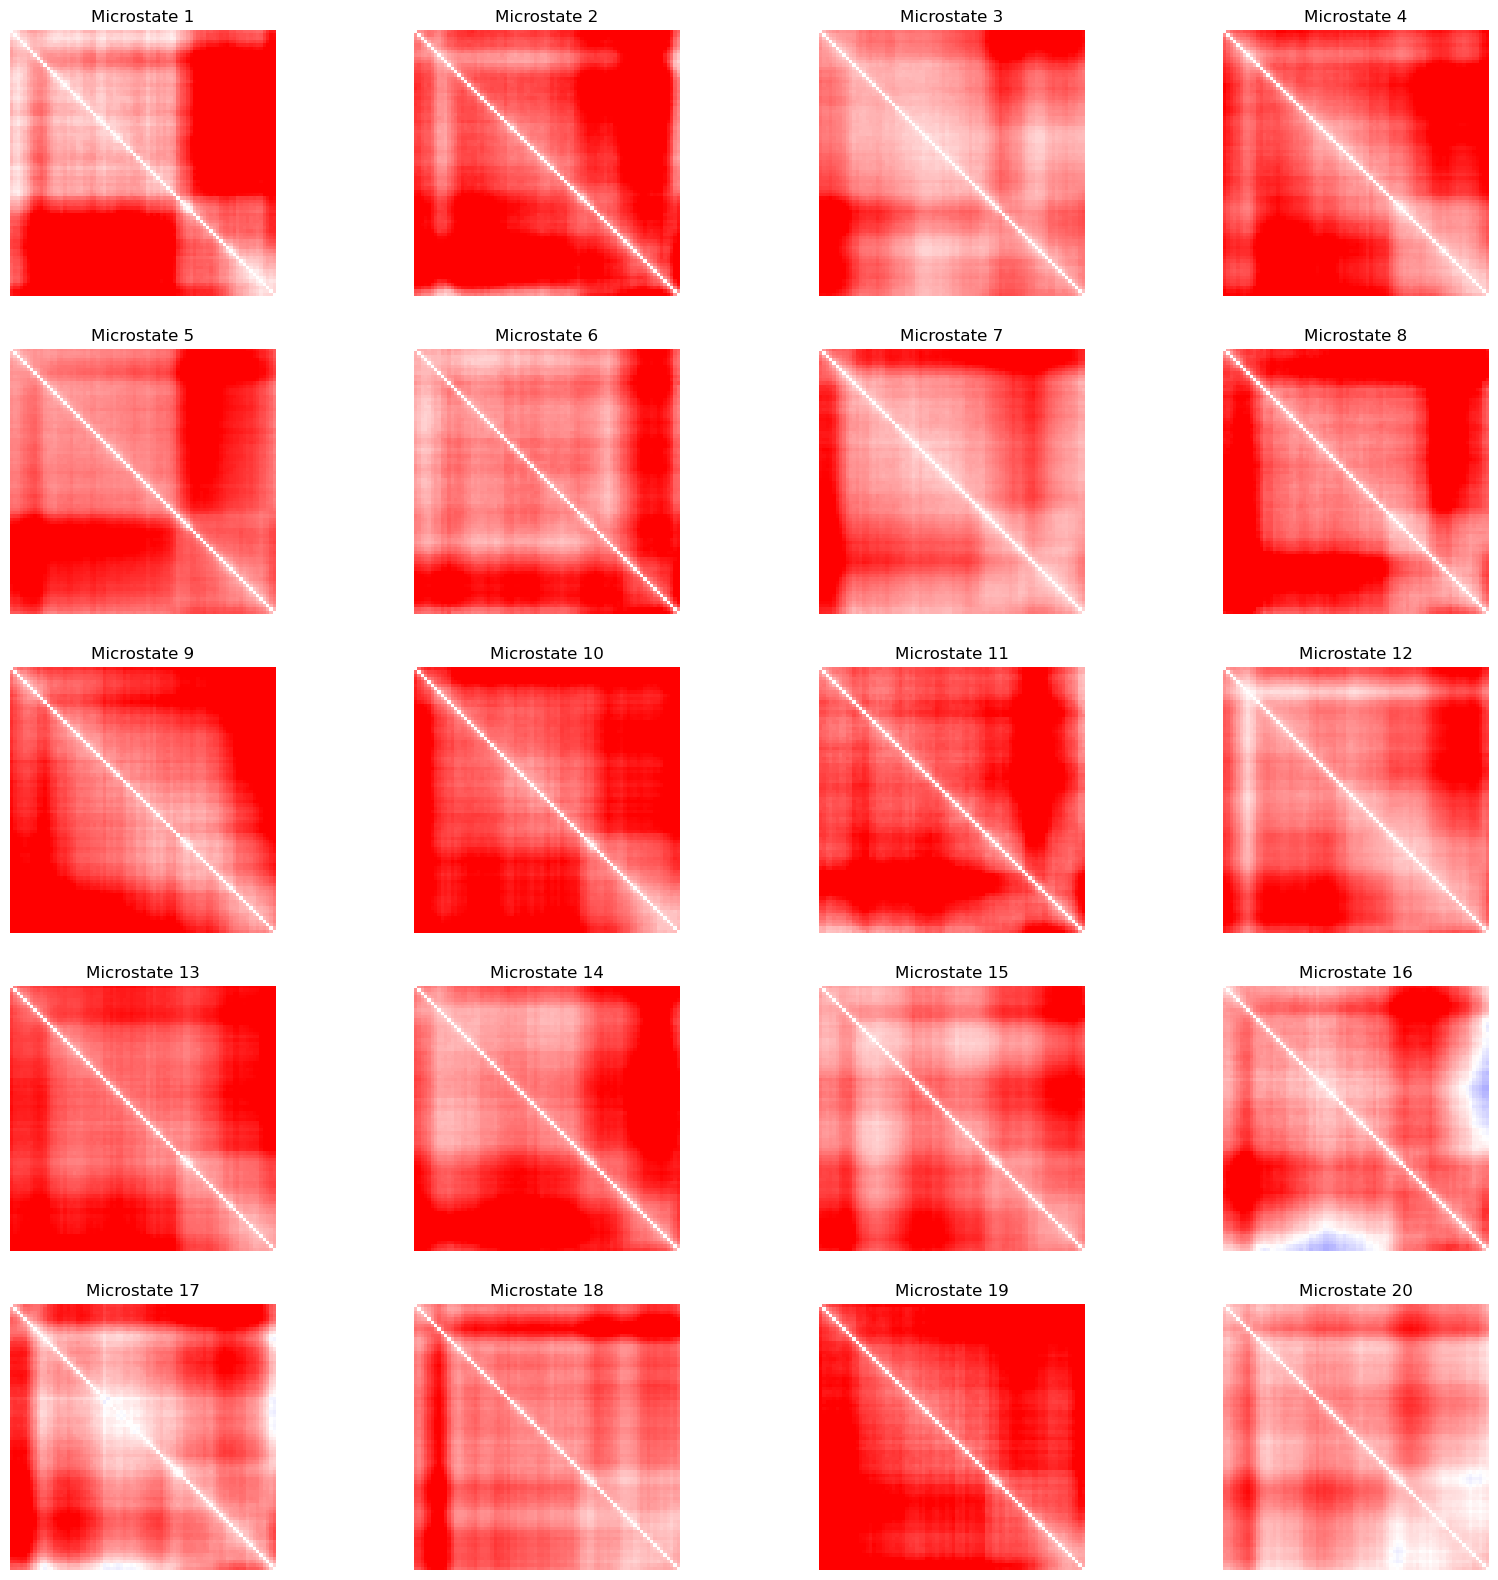

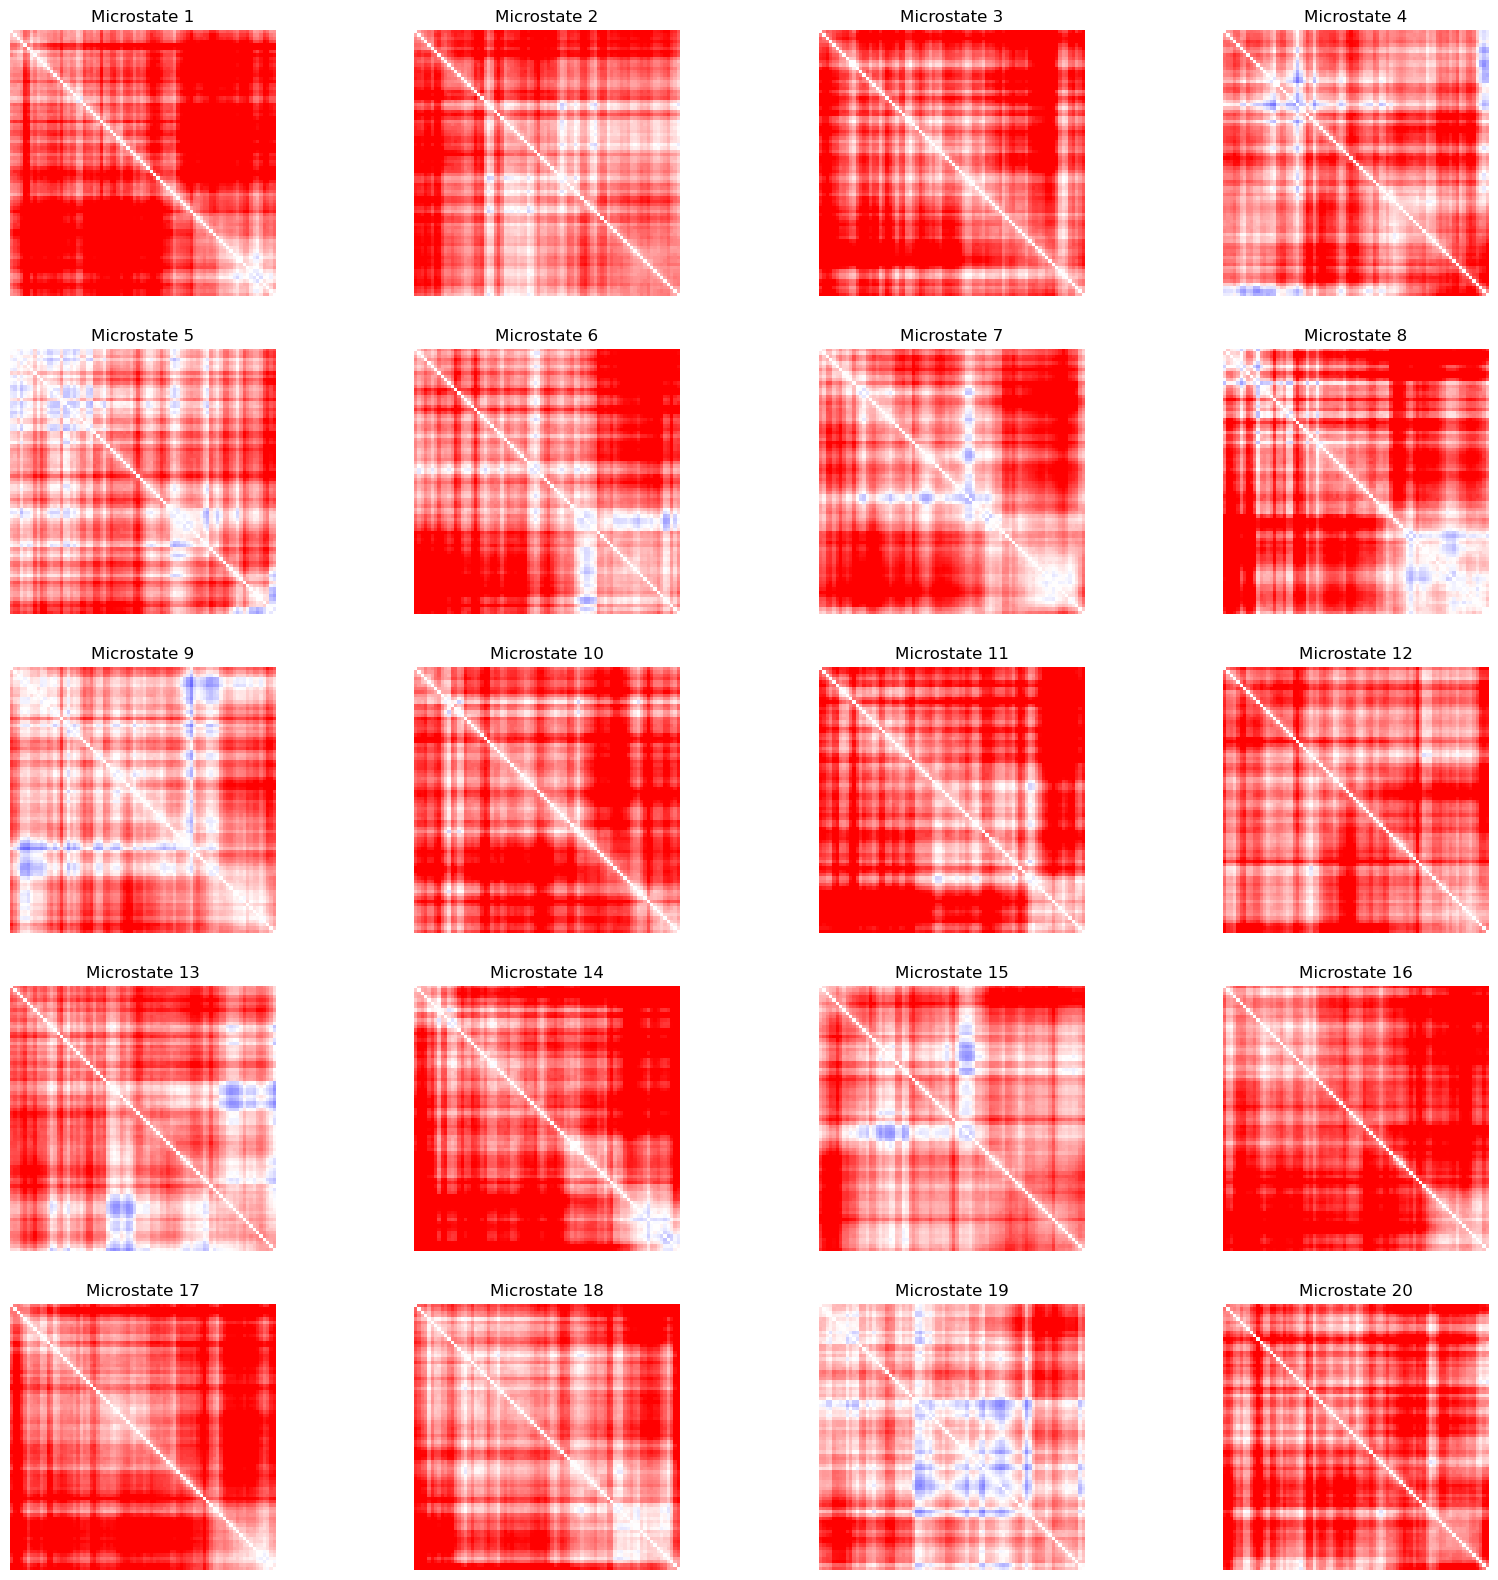

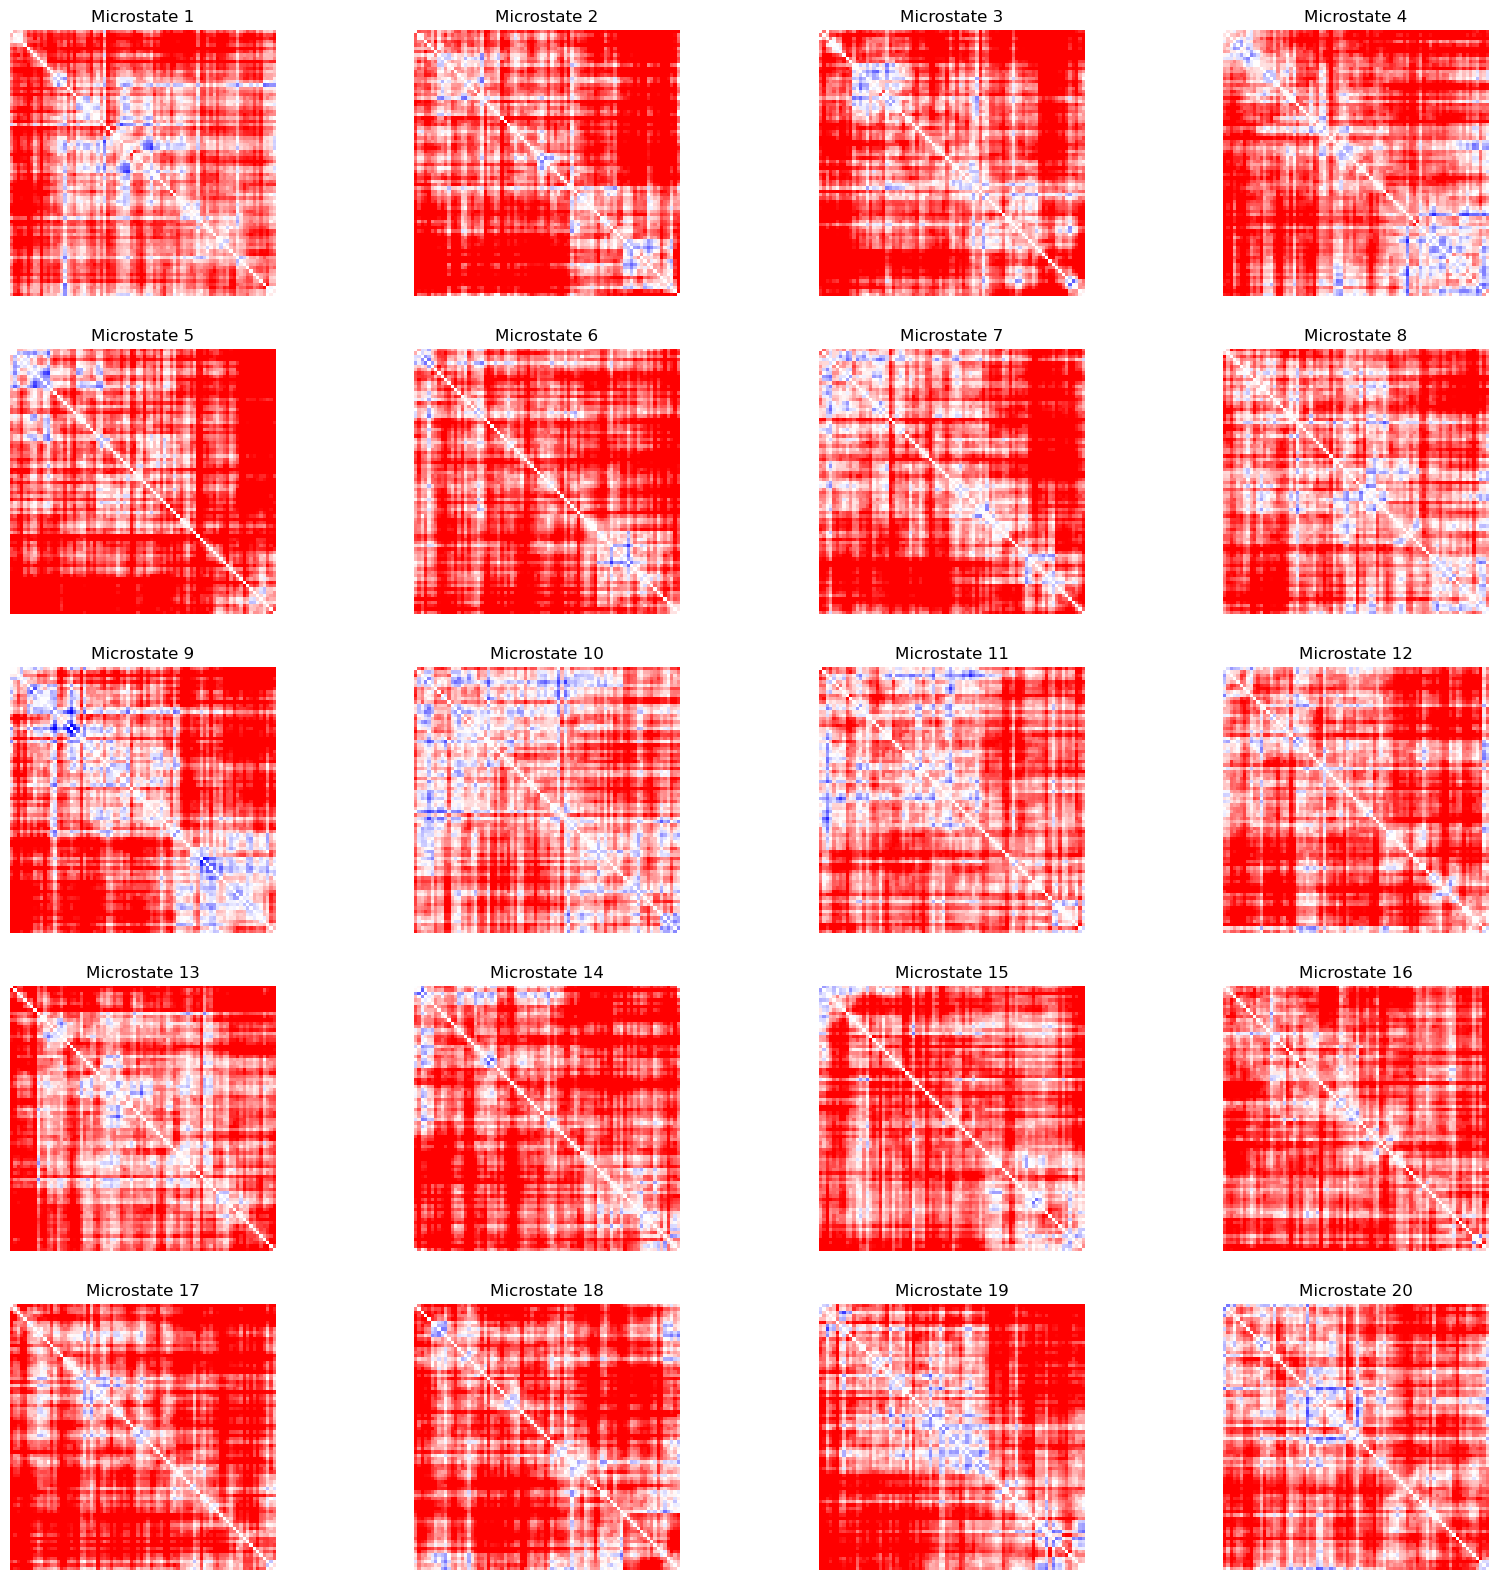

In [47]:
# Plot the distance maps of these medoids
for j, md in enumerate(microstates_list):
    md_maps = [x.reshape(80, 80) for x in md]
    num_maps = len(md_maps)
    
    # Plot the first 20 maps
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        if i < num_maps:
            ax.imshow(md_maps[i], cmap='bwr', vmin=-1000, vmax=1000)
            ax.set_title(f'Microstate {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.savefig(f'{save_dir}/LHS_medoids_{num_ranks[j]}_microstates.png')
    plt.show()

In [28]:
md_params[0]

,PC1,PC2
0,8820.694575,5306.740210
1,-21811.425880,5560.267458
2,-1477.605502,-4381.741637
3,4597.211045,12466.925481
4,16246.272363,6880.672044
...,...,...
995,15943.835270,-3722.708000
996,-980.232090,-8013.004169
997,16905.854248,6699.592994
998,-6788.063515,9350.804953


In [31]:
pca = PCA(n_components=None)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=[f'PC{i+1}' for i in range(esc_maps_pca.shape[1])])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=[f'PC{i+1}' for i in range(esc_maps_pca.shape[1])])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

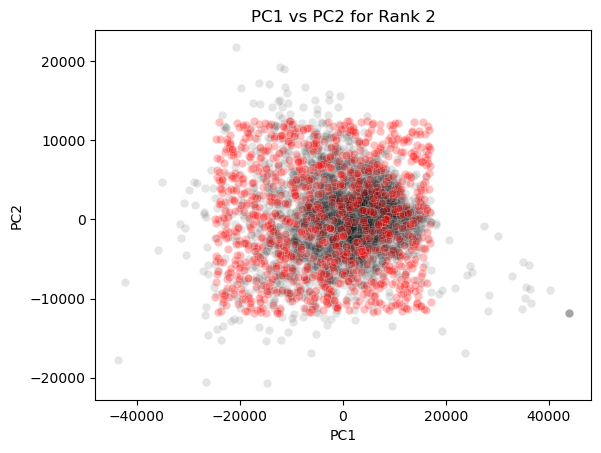

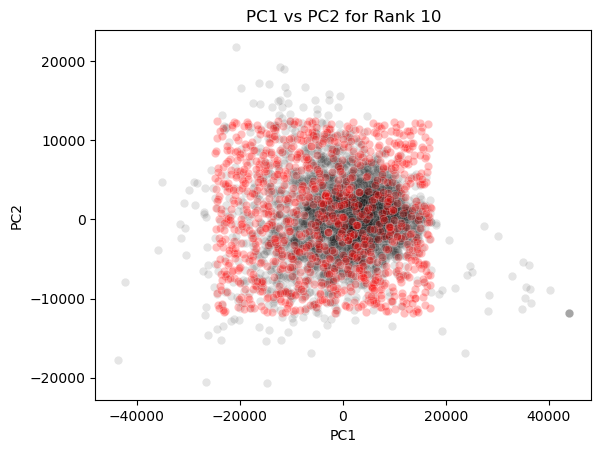

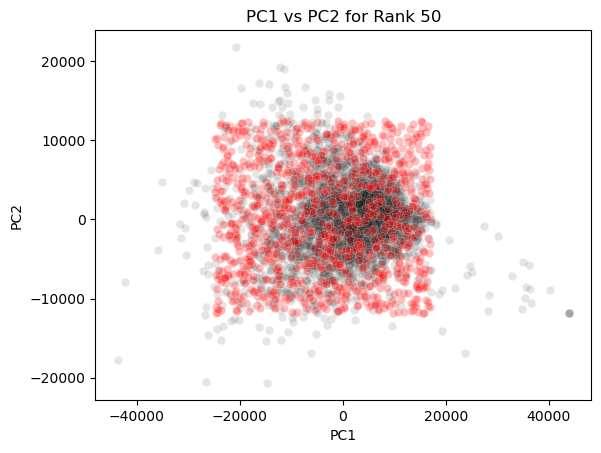

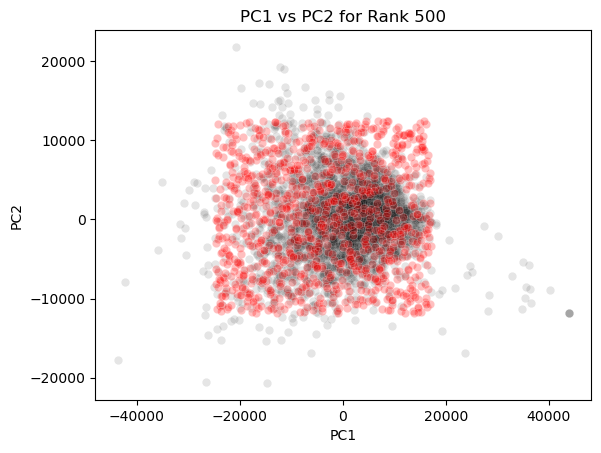

In [41]:
# Plot the distribution of these LHS on PC1 and PC2
for i, md in enumerate(md_params):
    sns.scatterplot(data=all_df, x='PC1', y='PC2', 
                    alpha=0.1, color='black', legend=False)
    sns.scatterplot(data=md, x='PC1', y='PC2', alpha=0.25, color='red', legend=False)
    plt.title(f'PC1 vs PC2 for Rank {num_ranks[i]}')
    plt.savefig(f'{save_dir}/LHS_PC1_PC2_{num_ranks[i]}_microstates.png')
    plt.show()

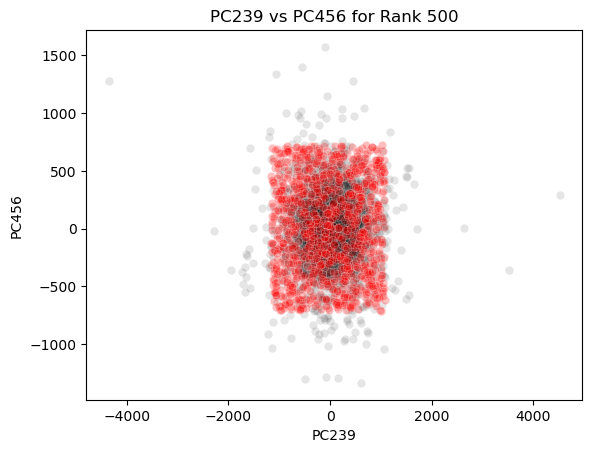

In [45]:
i = 3
x_axis = 'PC239'
y_axis = 'PC456'

sns.scatterplot(data=all_df, x=x_axis, y=y_axis, 
                    alpha=0.1, color='black', legend=False)
sns.scatterplot(data=md_params[i], x=x_axis, y=y_axis, alpha=0.25, color='red', legend=False)
plt.title(f'{x_axis} vs {y_axis} for Rank {num_ranks[i]}')
plt.savefig(f'{save_dir}/LHS_{x_axis}_{y_axis}_{num_ranks[i]}_microstates.png')
plt.show()